<font color = 'blue'>
Content: 


1. [Load Python Pakages](#1)
2. [First look to data](#2)
3. [Exploratory Data Analysis](#3)   
4. [Preprocessing](#6)
5. [Modeling](#9)
    * [XGBoost](#10)
    * [Lightgbm](#11)
    * [Catboost](#12)
6. [Performance Summary](#14)
7. [Voting vs Stacking](#15)
8. [Submission](#18)


<a id = "1"></a><br>
# Load Python Pakages


In [1]:
#basics
import numpy as np
import pandas as pd 
import seaborn as sns
import missingno as msno
from sklearn import set_config
from sklearn.base import clone
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


#preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, OrdinalEncoder
from category_encoders.target_encoder import TargetEncoder

#statistics
from scipy.stats import randint, mode

#transformers and pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline


#feature engineering
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import RFECV

#algorithms
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier
from lightgbm.callback import early_stopping, log_evaluation
from sklearn.linear_model import LogisticRegression


#model evaluation
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, confusion_matrix, matthews_corrcoef, make_scorer


#for algorithm run time comparison
import time

#define a random_state for reproducibility
random_state = 42

<a id = "2"></a><br>
#  First look to data

In [2]:
# Read the data
train_df = pd.read_csv('/kaggle/input/playground-series-s4e8/train.csv', index_col=[0])
test_df = pd.read_csv('/kaggle/input/playground-series-s4e8/test.csv', index_col=[0])

train_df.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
id,,,,,,,,,,,,,,,,,,,,,
0,e,8.80,f,s,u,f,a,c,w,4.51,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,p,4.51,x,h,o,f,a,c,n,4.79,...,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,e,6.94,f,s,b,f,x,c,w,6.85,...,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,e,3.88,f,y,g,f,s,NaN,g,4.16,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,e,5.85,x,l,w,f,d,NaN,w,3.37,...,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a


A lot of NaN's. Let's visualize the missing values.

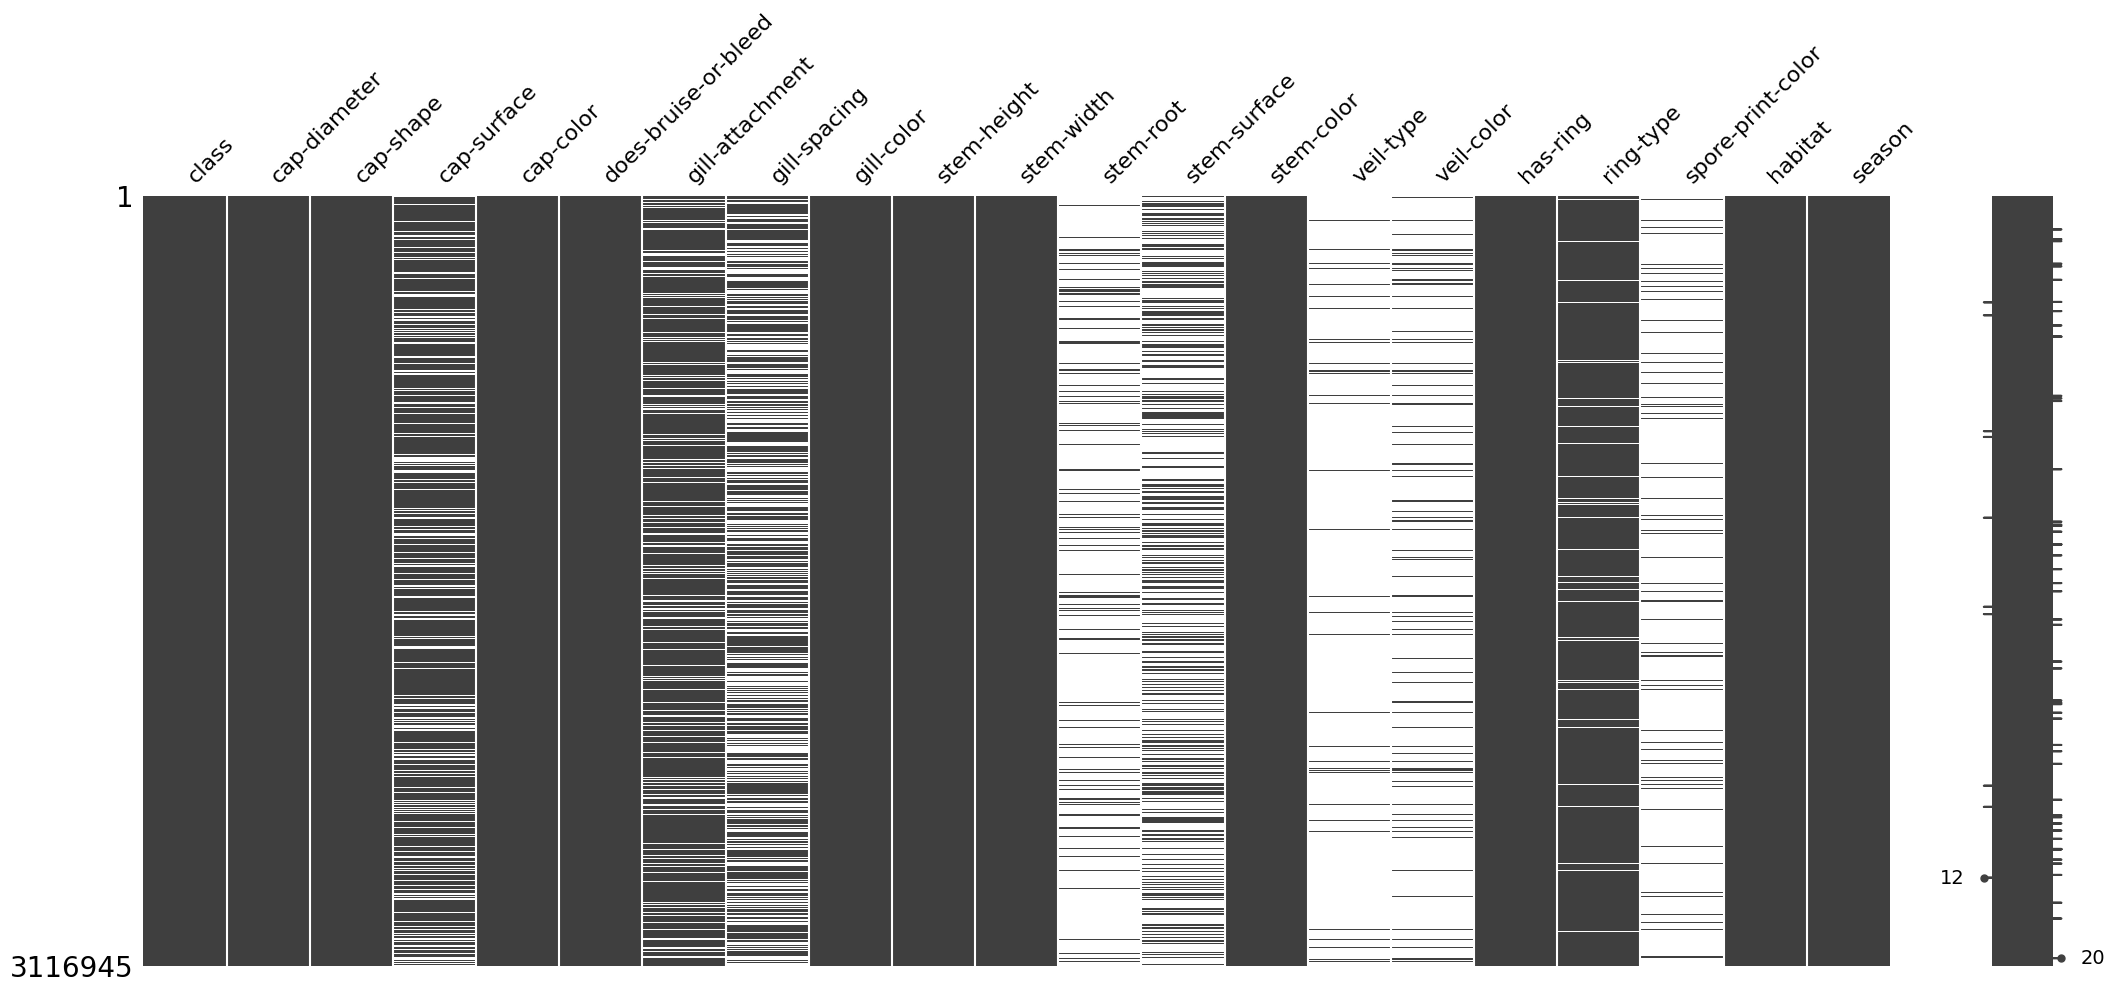

In [3]:
msno.matrix(train_df)
plt.show()

In [4]:
missing = pd.DataFrame(train_df.isnull().sum().sort_values(ascending=False))
missing.columns = ["missing_count"]
missing = missing.loc[(missing!=0).any(axis=1)]
missing["missing_percent"] = missing[0:] / len(train_df) *100
missing.style.background_gradient('viridis')

,missing_count,missing_percent
veil-type,2957493,94.884350
spore-print-color,2849682,91.425482
stem-root,2757023,88.452732
veil-color,2740947,87.936970
stem-surface,1980861,63.551362
gill-spacing,1258435,40.373988
cap-surface,671023,21.528227
gill-attachment,523936,16.809280
ring-type,128880,4.134818
gill-color,57,0.001829


<a id = "3"></a><br>
# Exploratory Data Analysis

<a id = "4"></a><br>
## Descpriptive statistics 

In [5]:
#descriptive statistics
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
cap-diameter,3116941.0,6.309848,4.657931,0.03,3.32,5.75,8.24,80.67
stem-height,3116945.0,6.348333,2.699755,0.00,4.67,5.88,7.41,88.72
stem-width,3116945.0,11.153785,8.095477,0.00,4.97,9.65,15.63,102.90


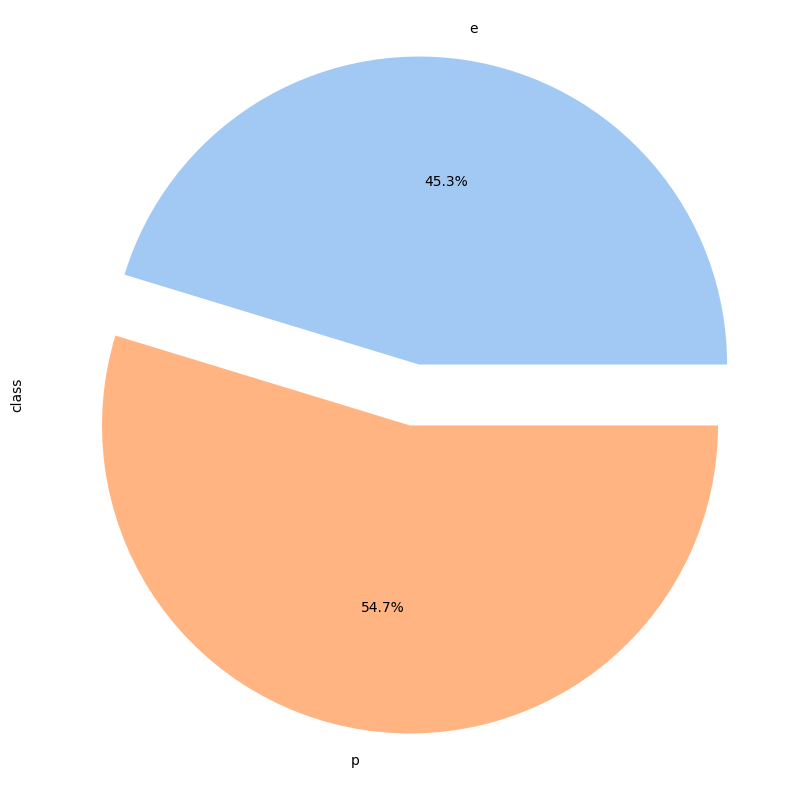

In [6]:
#Target Distribution plot
plt.figure(figsize=(10,10))
palette_color = sns.color_palette('pastel')
explode = [0.1, 0.1]
train_df.groupby('class')['class'].count().plot.pie(colors=palette_color,explode=explode, autopct="%1.1f%%");

In [7]:
le = LabelEncoder()

train_df['class'] = le.fit_transform(train_df['class'])

<a id = "5"></a><br>

## Grouping features for preprocessing purposes

In [8]:
# Store numerical and categorical features to different lists for visualization purposes
feature_list = [feature for feature in train_df.columns if not feature  == "class"]

target = "class"

numerical_features = ['stem-height', 'cap-diameter', 'stem-width']

categorical_features = list(set(feature_list) - set(numerical_features))

assert feature_list.sort() == (numerical_features + categorical_features).sort()

In [9]:
eda_df = train_df.sample(frac= 0.1, random_state=random_state)

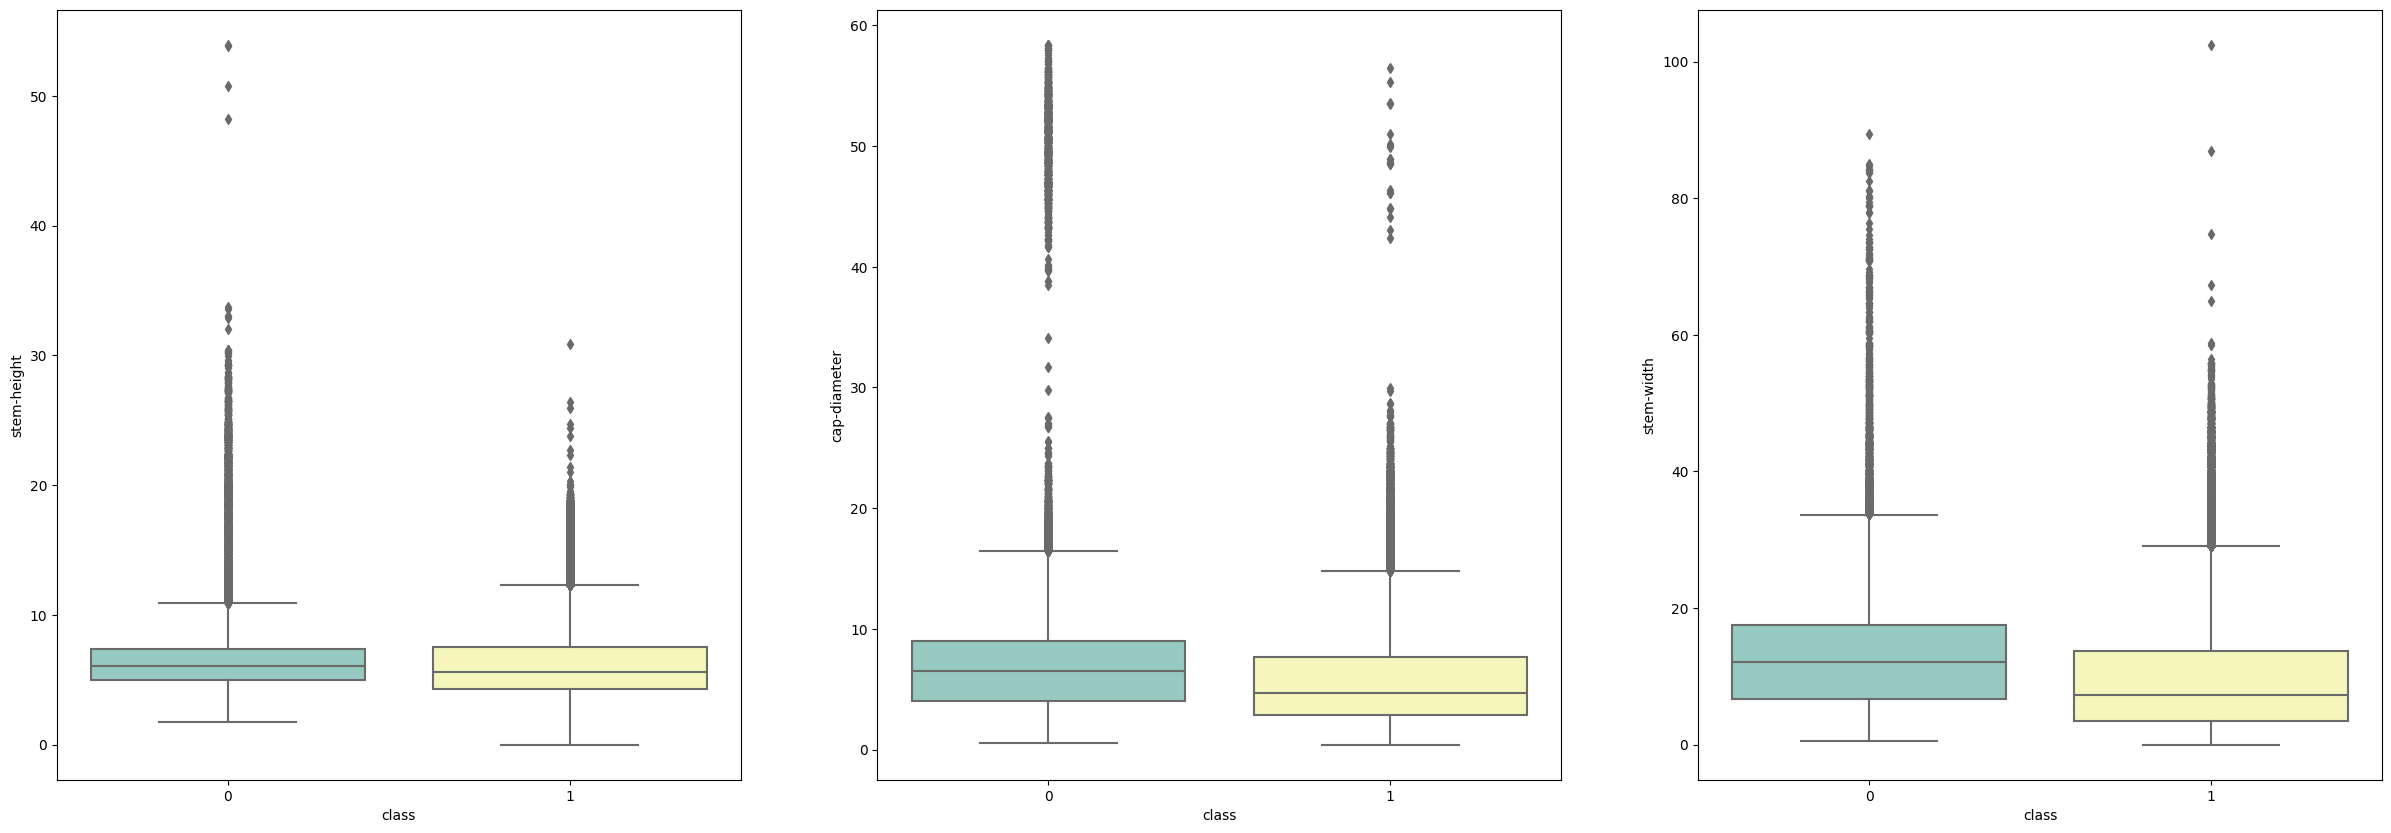

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(30, 10))
for var, subplot in zip(numerical_features, ax.flatten()):
    sns.boxplot(x='class', y=var, data=eda_df, ax=subplot, palette='Set3')

In [11]:
#check for cardinality
train_df[categorical_features].nunique().sort_values()

season                   4
veil-type               22
has-ring                23
veil-color              24
does-bruise-or-bleed    26
spore-print-color       32
stem-root               38
ring-type               40
gill-spacing            48
habitat                 52
stem-color              59
stem-surface            60
gill-color              63
cap-shape               74
cap-color               78
gill-attachment         78
cap-surface             83
dtype: int64

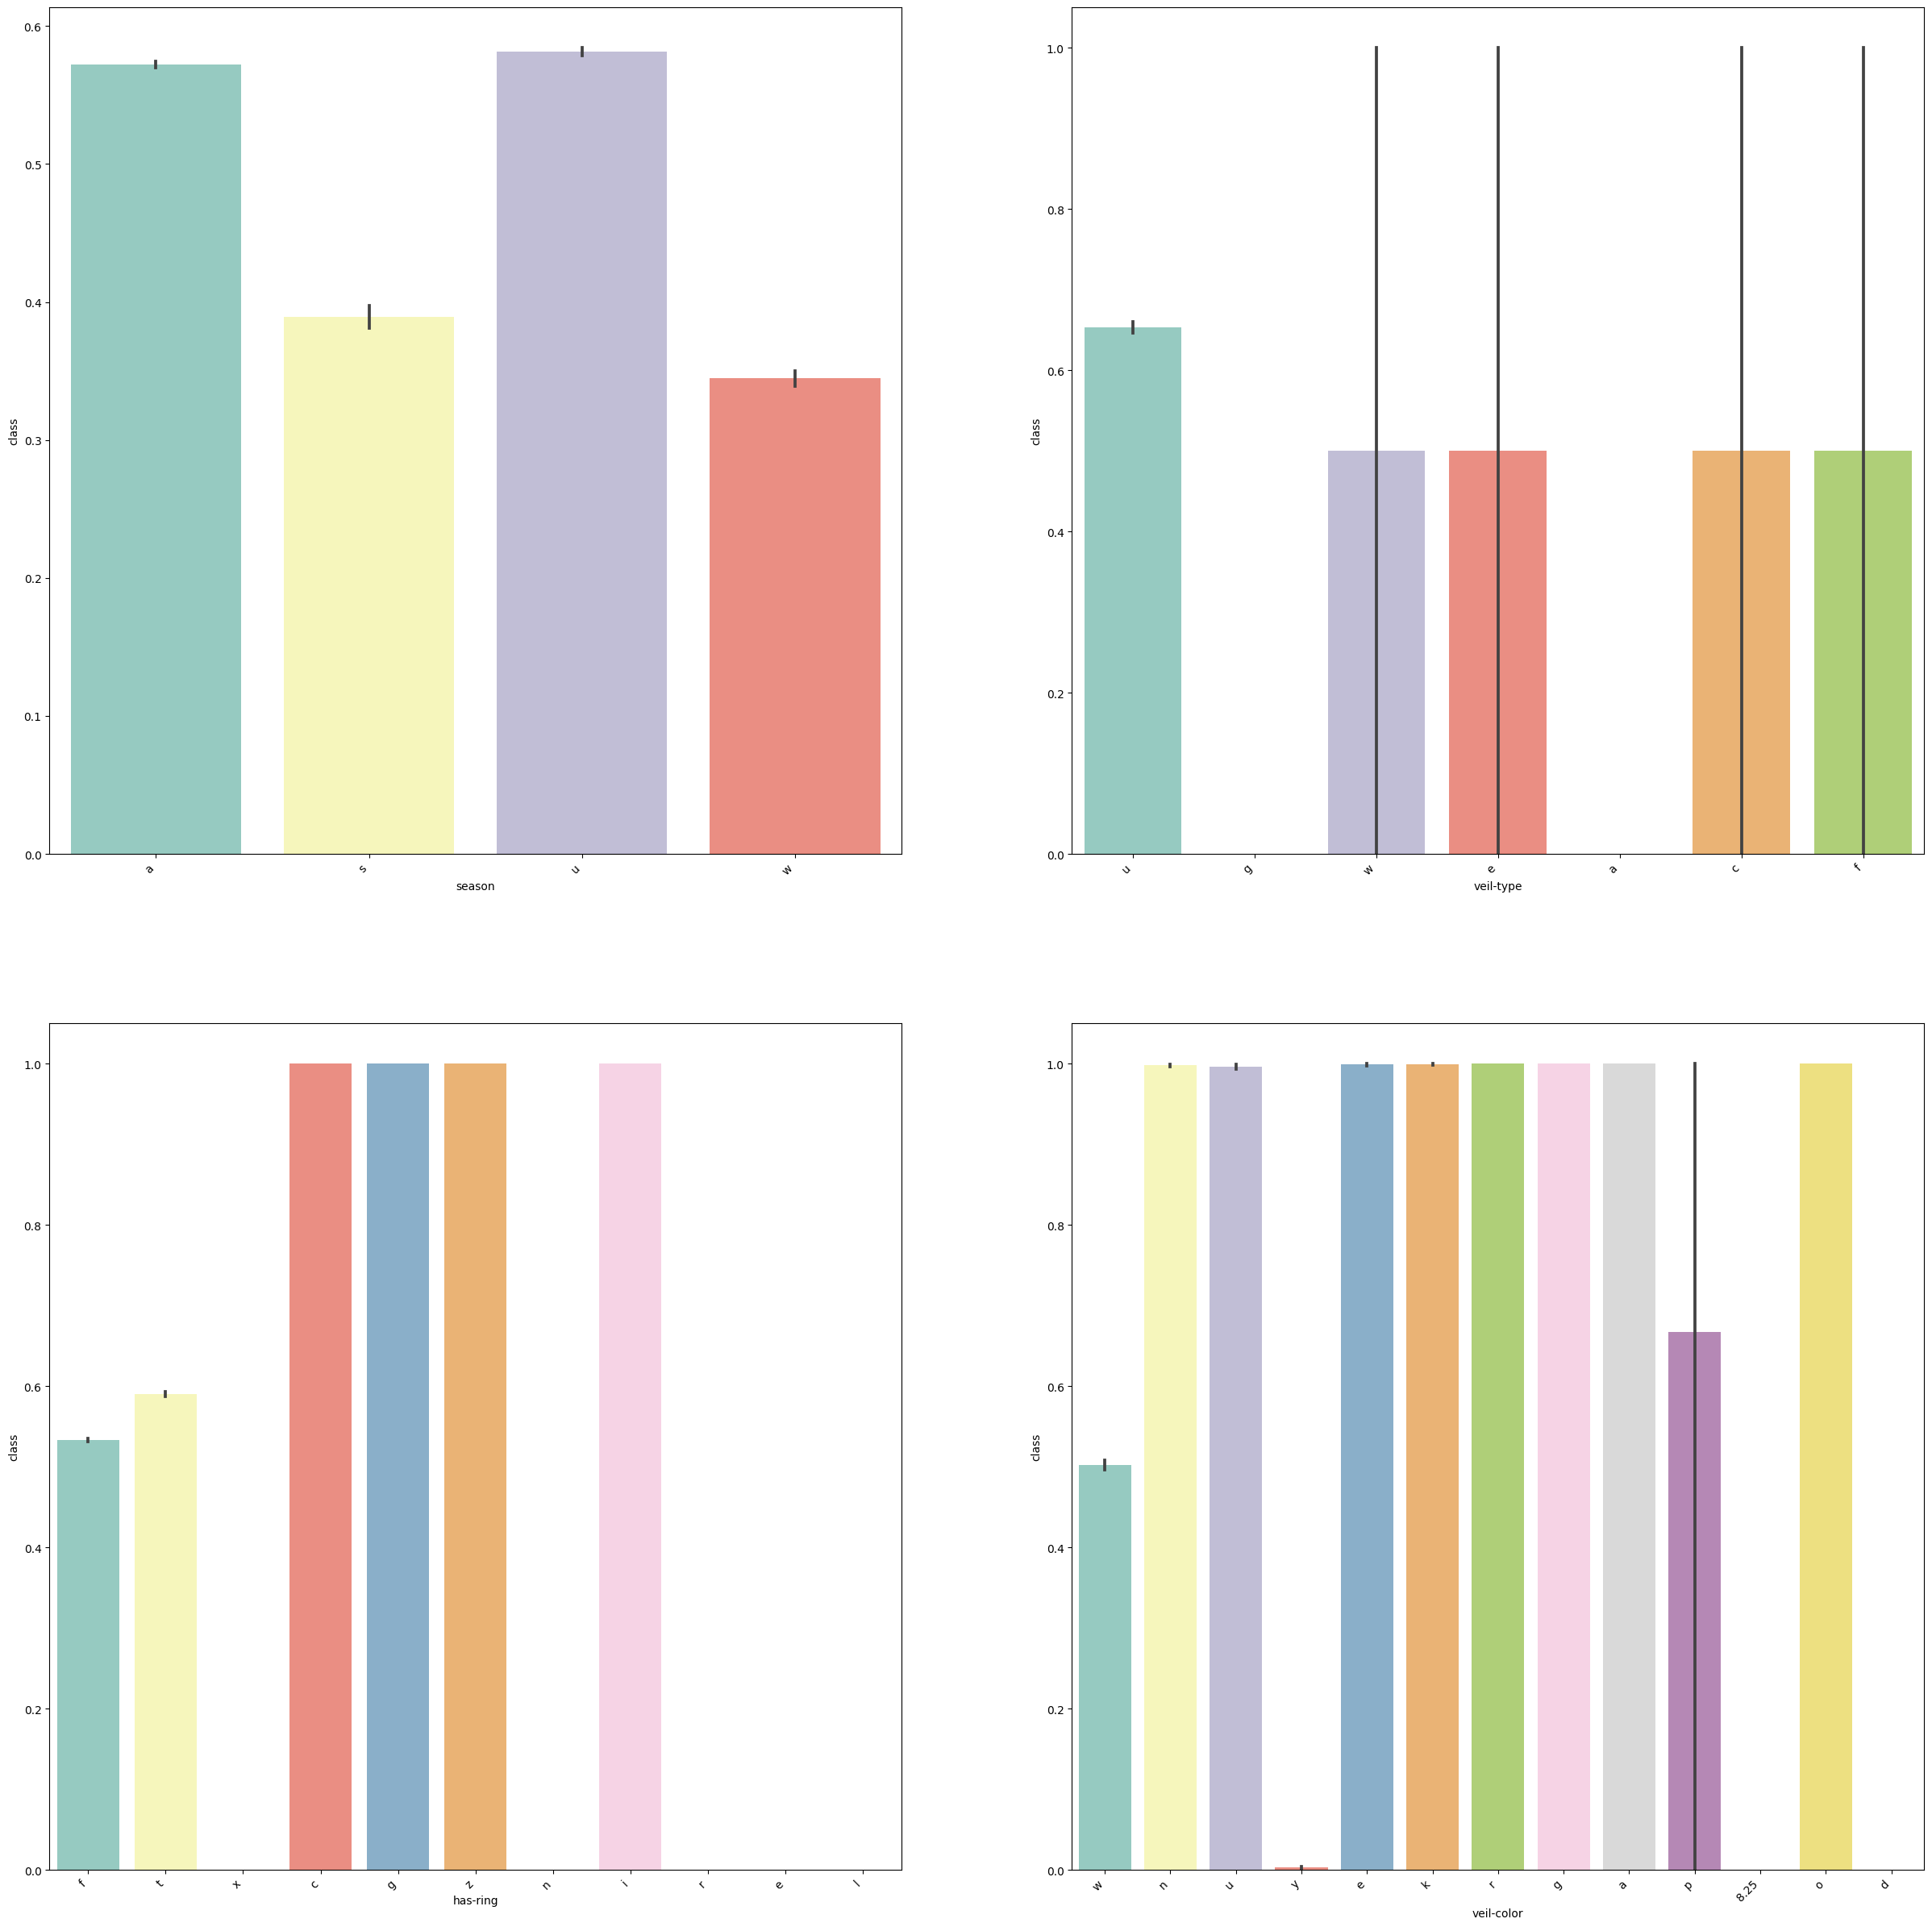

In [12]:
#Categoricals
#Just visualize moderate cardinality features
moderate_cardinality_features = ['season', 'veil-type', 'has-ring', 'veil-color']

fig, ax = plt.subplots(2, 2, figsize=(30, 30))
for var, subplot in zip(moderate_cardinality_features, ax.flatten()):
    sns.barplot(x=var,y= 'class',  data=eda_df, ax=subplot, palette='Set3')
    subplot.set_xticklabels(subplot.get_xticklabels(), rotation=45, ha='right')

* Very strong features. Some categories are dedicated to one class. For example, if the vell-type is 'l,' it is non-poisonous. If 't', it is poisonous.

In [13]:
# Mutual Information score
y_sampled = eda_df['class']
mutual_df = eda_df[numerical_features]

mutual_info = mutual_info_classif(mutual_df.fillna(0), y_sampled, random_state=random_state)

mutual_info = pd.Series(mutual_info)
mutual_info.index = mutual_df.columns
mutual_info = pd.DataFrame(mutual_info.sort_values(ascending=False), columns = ["Numerical_Feature_MI"] )
mutual_info.style.background_gradient("cool")

,Numerical_Feature_MI
stem-width,0.067187
cap-diameter,0.043046
stem-height,0.039790


In [14]:
mutual_df_categorical = eda_df[categorical_features]
#categorical features must be encoded to get mutual information
for colname in mutual_df_categorical:
    mutual_df_categorical[colname], _ = mutual_df_categorical[colname].factorize()
mutual_info = mutual_info_classif(mutual_df_categorical.fillna("Do_not_have_feature"), y_sampled, random_state=1)

mutual_info = pd.Series(mutual_info)
mutual_info.index = mutual_df_categorical.columns
pd.DataFrame(mutual_info.sort_values(ascending=False), columns = ["Categorical_Feature_MI"] ).style.background_gradient("cool")

,Categorical_Feature_MI
stem-root,0.050860
veil-color,0.049316
spore-print-color,0.047263
veil-type,0.036339
does-bruise-or-bleed,0.033026
gill-color,0.026048
ring-type,0.024590
cap-color,0.020567
stem-color,0.019285
cap-shape,0.016115


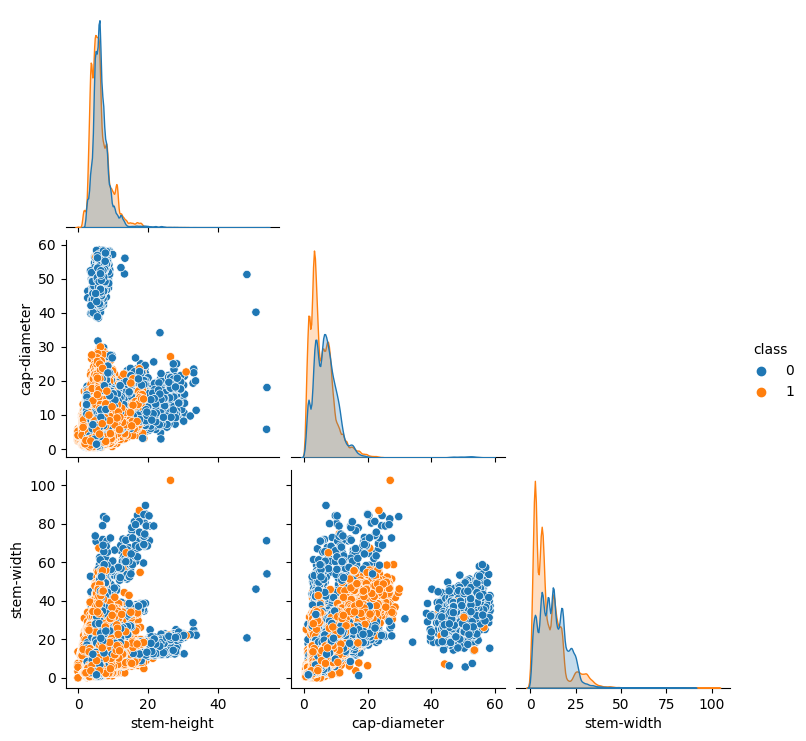

In [15]:
#Pair-plot for most important features
sns.pairplot(eda_df[numerical_features + ["class"]], hue="class",  corner=True)

<a id = "6"></a><br>
# Preprocessing

In [16]:
#Converts object types to category
#reference for why we would do that?: https://catboost.ai/en/docs/concepts/speed-up-training
train_df[categorical_features] = train_df[categorical_features].astype('category')
test_df[categorical_features] = test_df[categorical_features].astype('category')


In [17]:
#Catboost complains about missing value format
def preprocess_catboost(train_df, test_data, cat_features):
    for col in cat_features:
        train_df[col] = train_df[col].astype(str).fillna('NaN')
        test_data[col] = test_data[col].astype(str).fillna('NaN')
    return train_df, test_data

In [18]:
# For XGB
#Check this discussion to see how XGB fails to handle cat features:
#https://www.kaggle.com/competitions/playground-series-s4e8/discussion/523781#2945249
encoder  = ColumnTransformer(remainder='passthrough',
    transformers=[
        ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_features),
    ])

encoder


ColumnTransformer(remainder='passthrough',
                  transformers=[('encoder',
                                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 ['gill-spacing', 'cap-color',
                                  'gill-attachment', 'veil-type',
                                  'does-bruise-or-bleed', 'stem-surface',
                                  'spore-print-color', 'ring-type',
                                  'veil-color', 'stem-color', 'has-ring',
                                  'stem-root', 'habitat', 'season', 'cap-shape',
                                  'gill-color', 'cap-surface'])])

<a id = "9"></a><br>
# Modeling

In [19]:
#seperate target
y = train_df['class']
train_df = train_df.drop(['class'], axis=1)

In [20]:
#CV strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

In [21]:
def cross_validate_score(model, train_df, y, cv, test_data):
    val_scores = []
    test_preds = np.zeros((test_data.shape[0],))
    oof_preds = np.zeros((train_df.shape[0],))

    if isinstance(model, CatBoostClassifier):
        cat_features = model.get_params().get('cat_features', [])
        train_df, test_data = preprocess_catboost(train_df, test_data, cat_features)

    for fold, (train_idx, val_idx) in enumerate(cv.split(train_df, y)):
        X_train = train_df.iloc[train_idx].reset_index(drop=True)
        y_train = y.iloc[train_idx].reset_index(drop=True)
        
        X_val = train_df.iloc[val_idx].reset_index(drop=True)
        y_val = y.iloc[val_idx].reset_index(drop=True)
        
        model = clone(model)

        eval_set = [(X_val, y_val)]

        if isinstance(model, LGBMClassifier):
            model.fit(
                X_train, y_train,
                eval_set=eval_set,
                callbacks=[early_stopping(50)],
            )
        elif isinstance(model, CatBoostClassifier):
            model.fit(
                X_train, y_train,
                eval_set=eval_set,
                early_stopping_rounds=50,
                verbose=False
            )

        else:
            model.fit(
                X_train, y_train,

            )
        
        val_probs = model.predict_proba(X_val)[:, 1]  # Get the probabilities
        val_preds = (val_probs > 0.5).astype(int)     # Convert probabilities to class labels for MCC

        val_score = matthews_corrcoef(y_val, val_preds)  # Calculate MCC
        print(f'Fold {fold}: MCC = {val_score:.5f}')
        
        val_scores.append(val_score)
        
        oof_preds[val_idx] = val_probs  # Store the probabilities for OOF predictions

        test_preds += model.predict_proba(test_data)[:, 1] / cv.get_n_splits()  # Aggregate test probabilities

    mean_val_score = np.mean(val_scores)
    std_val_score = np.std(val_scores)
    print(f'Mean Validation MCC: {mean_val_score:.7f}')
    print(f'Std Validation MCC: {std_val_score:.7f}')
    
    return val_scores, test_preds, oof_preds


In [22]:
cv_summary, test_preds, oof_preds = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

<a id = "10"></a><br>
## XGboost

In [23]:
xgb_optuna_params = {
 'tree_method': 'gpu_hist',
 'n_estimators': 1696,
 'alpha': 4.956752183261538e-07,
 'subsample': 0.7349948172684168,
 'colsample_bytree': 0.30171411525842506,
 'max_depth': 15, 
 'min_child_weight': 6,
 'learning_rate': 0.013301072238797047,
 'gamma': 5.634602153104516e-08
}


xgb_tuned = XGBClassifier(**xgb_optuna_params, random_state=random_state)


xgb_pipeline = make_pipeline(encoder, xgb_tuned)

In [24]:
%%time
cv_summary['xgb'], test_preds['xgb'], oof_preds['xgb'] = cross_validate_score(xgb_pipeline, train_df , y,  cv, test_df)

Fold 0: MCC = 0.98475
Fold 1: MCC = 0.98476
Fold 2: MCC = 0.98484
Fold 3: MCC = 0.98461
Fold 4: MCC = 0.98489
Mean Validation MCC: 0.9847692
Std Validation MCC: 0.0000969
CPU times: user 12min 59s, sys: 11.3 s, total: 13min 10s
Wall time: 12min 31s


<a id = "11"></a><br>
## Lightgbm

In [25]:
lgbm_optuna_params = {
    'n_estimators': 10000,
    'learning_rate': 0.02,
    "categorical_feature" : categorical_features,
    'device': 'gpu',
    'max_depth': 10,
    'min_data_in_leaf': 85,
    'subsample': 0.6720606456166781,
    'max_bin': 240,
    'feature_fraction': 0.6946327643448142,

}



lgbm_tuned = LGBMClassifier(**lgbm_optuna_params, random_state=random_state, verbose=-1)


In [26]:
%%time
cv_summary['lgbm'], test_preds['lgbm'], oof_preds['lgbm'] = cross_validate_score(lgbm_tuned, train_df , y,  cv, test_df)

1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5360]	valid_0's binary_logloss: 0.036242
Fold 0: MCC = 0.98456
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5908]	valid_0's binary_logloss: 0.0361577
Fold 1: MCC = 0.98459
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4609]	valid_0's binary_logloss: 0.0362929
Fold 2: MCC = 0.98456
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5744]	valid_0's binary_logloss: 0.0364362
Fold 3: MCC = 0.98444
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5307]	valid_0's binary_logloss: 0.0363482
Fold 4: MCC = 0.98453
Mean Validation MCC: 0.9845359
Std Validation MCC: 0.0000515
CPU times: user 3h 52min 27s, sys: 50.7 s, total: 3h 53min 17s
Wall time: 1h 55min 15s


<a id = "12"></a><br>
## Catboost

In [27]:
#Parameters found tuning process by Optuna
catb_params = {    
    "n_estimators" : 10000,
    "learning_rate" : 0.075,
    'cat_features' : categorical_features,
    'task_type': 'GPU',
    'random_strength': 0.3718364180573207,
    'max_bin': 128,
    'depth': 9,
    'l2_leaf_reg': 6,
    'grow_policy': 'SymmetricTree',
    'boosting_type': 'Plain',
    'bootstrap_type': 'Bernoulli',
    'subsample': 0.41936688658110405
}

# Catb with found hyperparameters
catb_tunned = CatBoostClassifier(**catb_params, random_state=random_state)


In [28]:
%%time
cv_summary['catb'], test_preds['catb'], oof_preds['catb'] = cross_validate_score(catb_tunned, train_df , y,  cv, test_df)

Fold 0: MCC = 0.98458
Fold 1: MCC = 0.98448
Fold 2: MCC = 0.98460
Fold 3: MCC = 0.98440
Fold 4: MCC = 0.98465
Mean Validation MCC: 0.9845426
Std Validation MCC: 0.0000908
CPU times: user 2h 48min 43s, sys: 3min 24s, total: 2h 52min 8s
Wall time: 1h 55min 16s


<a id = "14"></a><br>
## Performance Summary

In [29]:
#performance summary for base learners
transposed_df = cv_summary.transpose()
transposed_df.columns = ['fold1','fold2','fold3','fold4','fold5']
transposed_df['Mean'] = transposed_df.mean(axis=1)
transposed_df['Std'] = transposed_df.std(axis=1)
transposed_df.sort_values(by = 'Mean', ascending=False).style.background_gradient('Dark2_r')

,fold1,fold2,fold3,fold4,fold5,Mean,Std
xgb,0.984746,0.984760,0.984837,0.984608,0.984895,0.984769,0.000097
catb,0.984584,0.984484,0.984597,0.984397,0.984652,0.984543,0.000091
lgbm,0.984558,0.984595,0.984558,0.984443,0.984526,0.984536,0.000052


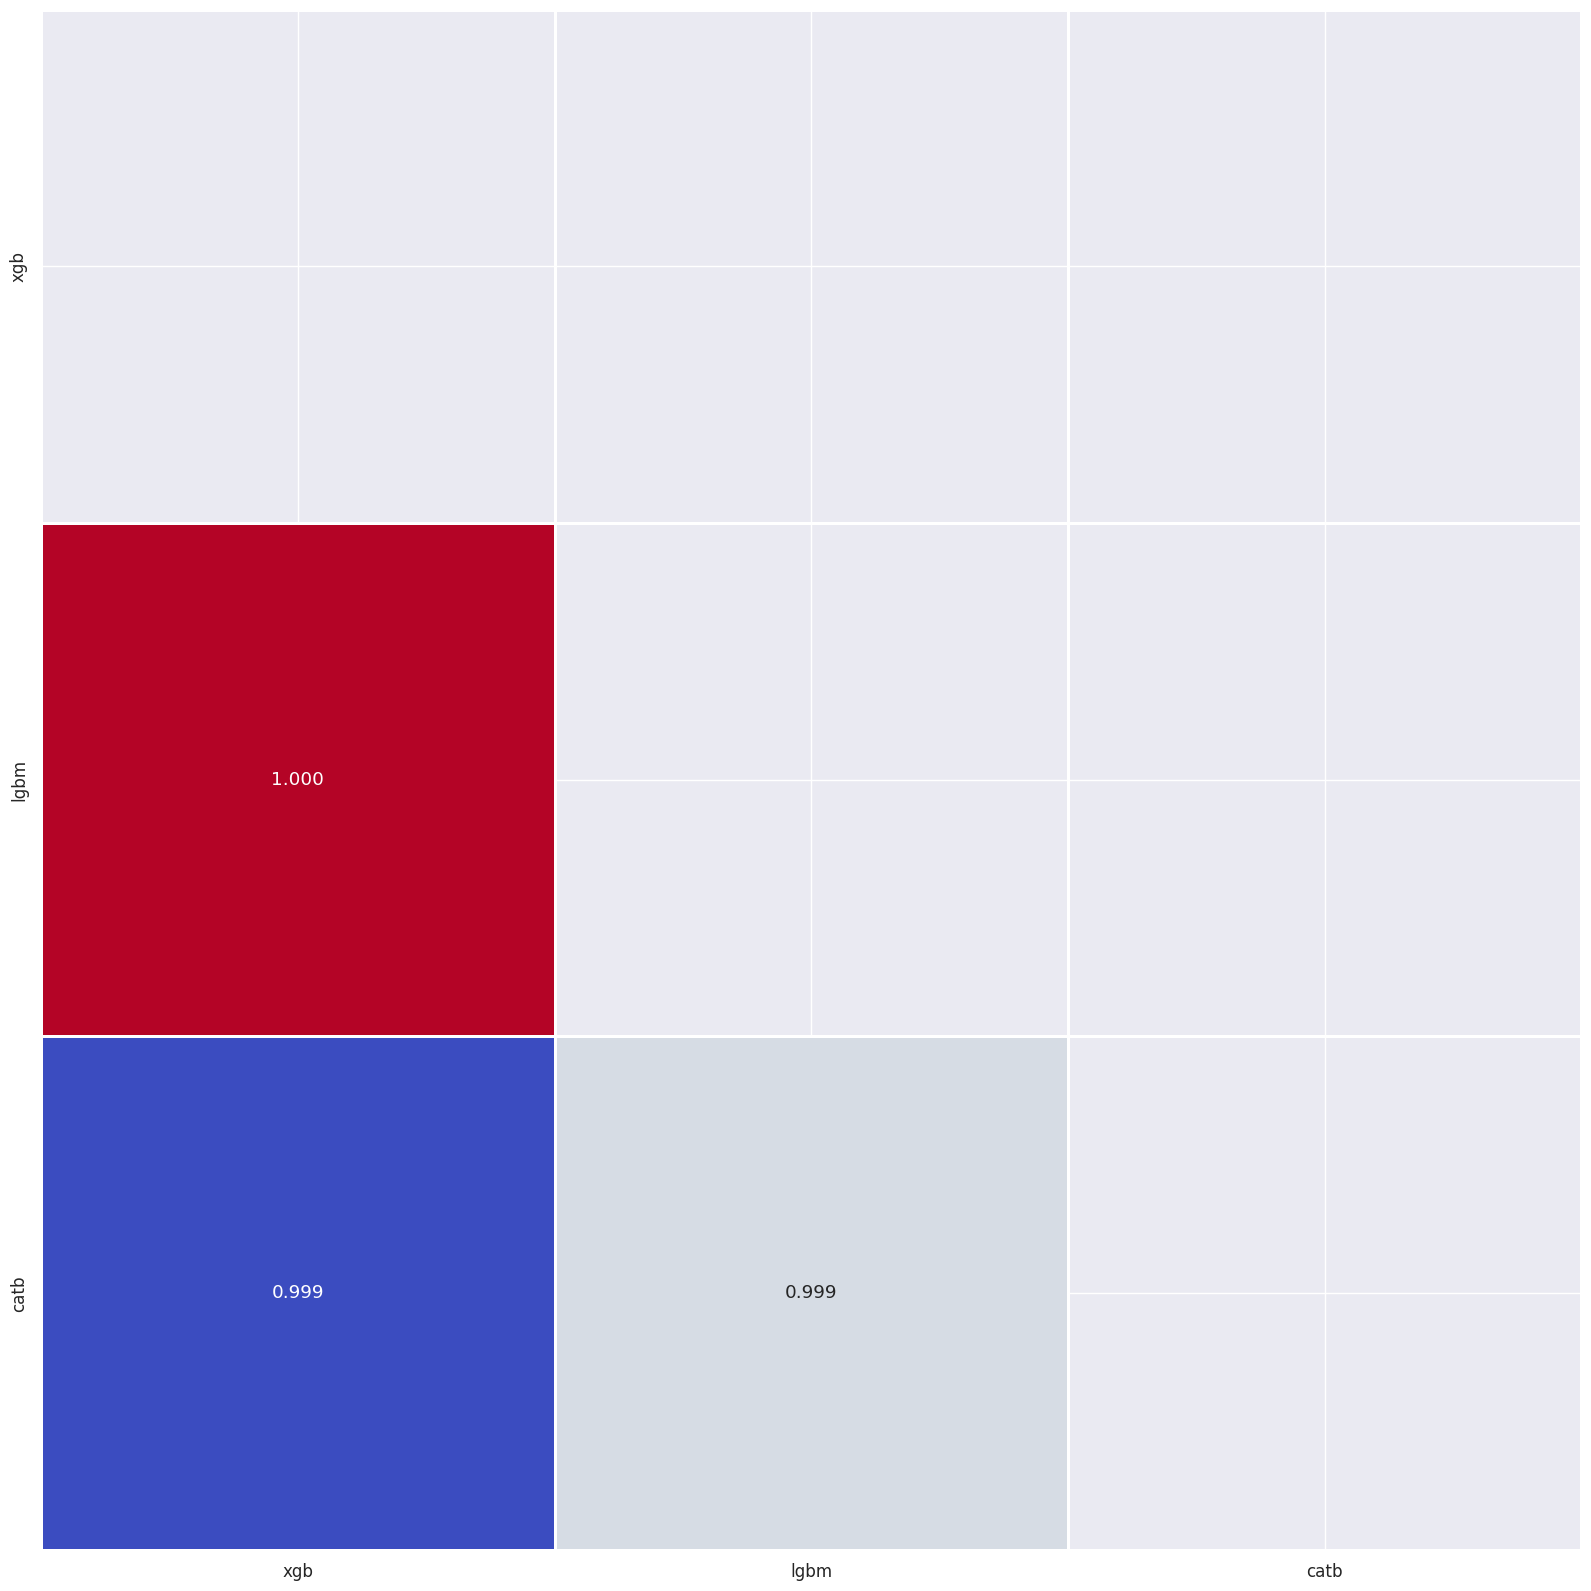

In [30]:
# Model diversity check

sns.set(font_scale=1.1)
correlation_train = oof_preds.corr()
mask = np.triu(correlation_train.corr())
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_train,
            annot=True,
            fmt='.3f',
            cmap='coolwarm',
            square=True,
            mask=mask,
            linewidths=1,
            cbar=False);

<a id = "15"></a><br>
## Voting vs Stacking

<a id = "16"></a><br>
## Voting

In [31]:
#voting hard & soft
def voting_ensemble(oof_preds, y, threshold=0.5, voting_type='soft'):
    if voting_type == 'soft':
        ensemble_preds = oof_preds.mean(axis=1)
        ensemble_class_preds = (ensemble_preds > threshold).astype(int)
        
    elif voting_type == 'hard':
        binary_preds = (oof_preds > threshold).astype(int)
        ensemble_class_preds = mode(binary_preds, axis=1)[0].flatten()
    
    mcc_score = matthews_corrcoef(y, ensemble_class_preds)
    
    return mcc_score



In [32]:
voting_ensemble(oof_preds, y, voting_type='soft')

0.9848518532477786

In [33]:
voting_ensemble(oof_preds, y, voting_type='hard')

0.9848110067247896

<a id = "17"></a><br>
## Stacking 

In [34]:
#parameters for meta model                                                                                                 
meta_model_params = {
    'C': 0.000237302749626327,
    'max_iter': 2500,
    'tol': 9.996751434702547e-05,
    'solver': 'saga',
    'penalty': 'l1'
}

meta_model = LogisticRegression(**meta_model_params, random_state=random_state)

In [35]:
%%time

#Deciding which models to include ensemble

min_features_to_select = 1

# Create a pipeline with preprocessor and RFECV
pipeline = Pipeline([
    
    ('Scaler', StandardScaler()),
    ('rfecv', RFECV(estimator=meta_model,
                    step=1,
                    cv=cv,
                    scoring=make_scorer(matthews_corrcoef),
                    min_features_to_select=min_features_to_select,
                    n_jobs=-1,))
])

# Fit the pipeline on oof_preds
pipeline.fit(oof_preds, y)

#CV score
print("Best CV score: ")
selected_models = np.array( oof_preds.columns)[pipeline.named_steps['rfecv'].support_]
print( pipeline.named_steps['rfecv'].cv_results_["mean_test_score"][len(selected_models) - 1])


# Selected models after RFECV
print('Number of available models:', len(oof_preds.columns))
print('Number of selected models for ensemble:', len(selected_models))
print("Selected models:", selected_models)

Best CV score: 
0.9848981595153127
Number of available models: 3
Number of selected models for ensemble: 3
Selected models: ['xgb' 'lgbm' 'catb']
CPU times: user 39.1 s, sys: 725 ms, total: 39.9 s
Wall time: 2min 3s


In [36]:
meta_model = meta_model.fit(oof_preds[selected_models], y)

In [37]:
preds_test =  meta_model.predict(test_preds[selected_models])

In [38]:
preds_test = le.inverse_transform(preds_test)


<a id = "18"></a><br>
# Submission

In [39]:
output = pd.DataFrame({'id': test_df.index,
                       'class': preds_test})


In [40]:
output.to_csv('submission.csv', index=False)

In [41]:
output.head()

,id,class
0,3116945,e
1,3116946,p
2,3116947,p
3,3116948,p
4,3116949,e


In [42]:
#save oofs and test predictions for later usage
oof_preds.to_parquet('oof_predictions_v01.parquet', index=False)
test_preds.to_parquet('test_predictions_v01.parquet', index=False)